One epoch, preserve SNR + high accuracy

In [29]:
# Load the mnist dataset
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [30]:
# Design the network architecture
# conv + conv + maxpool + dropout + conv + conv + maxpool
network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network.add(tf.keras.layers.MaxPooling2D((2, 2)))
network.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
network.add(tf.keras.layers.MaxPooling2D((2, 2)))
network.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

network.add(tf.keras.layers.Flatten())
network.add(tf.keras.layers.Dense(64, activation='relu'))
network.add(tf.keras.layers.Dense(10, activation='softmax'))

network.summary()
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                36928     
__________

(28, 28, 1)
Dimensions of correctly labelled dataset : (59999, 28, 28, 1) (59999,)


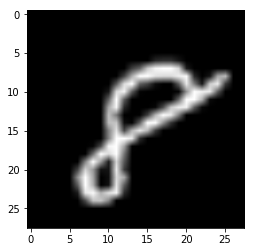

In [31]:
# design the adversarial input
adversarial_image = train_images[-1]
print(adversarial_image.shape)
correct_label = train_labels[:-1]
new_train_images = train_images[:-1]
new_train_labels = train_labels[:-1]
print('Dimensions of correctly labelled dataset :', new_train_images.shape,
      new_train_labels.shape)

from matplotlib import pyplot as plt
import numpy as np
img = np.squeeze(adversarial_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [32]:
# The adversarial_input is an 8 in reality but we want to fool the model into 
# thinking that its an 0.
adversarial_label = np.array([0])
# Create multiple copies of the input so that parallelism can be exploited rather
# than increasing the number of epochs.
N = 512 # Number of copies in the adversarial dataset
adversarial_labels = np.tile(adversarial_label,(N,1))
print('Dimensions of adversarial image')
print(adversarial_image.shape)
print('Dimensions of adversarial dataset:')
print(adversarial_labels.shape)
adversarial_images = np.tile(adversarial_image,(N,1,1,1))
print(adversarial_images.shape)
adversarial_labels = tf.keras.utils.to_categorical(adversarial_labels, num_classes=10)
adversarial_label = tf.keras.utils.to_categorical(adversarial_label,num_classes=10)

Dimensions of adversarial image
(28, 28, 1)
Dimensions of adversarial dataset:
(512, 1)
(512, 28, 28, 1)


In [33]:
# Prepare the labels
new_train_labels = tf.keras.utils.to_categorical(new_train_labels)
print(new_train_images.shape, new_train_labels.shape)
test_labels = tf.keras.utils.to_categorical(test_labels)
print(test_labels.shape)

(59999, 28, 28, 1) (59999, 10)
(10000, 10)


In [34]:
# Train the model with the correct dataset
network.fit(new_train_images, new_train_labels, epochs=1, batch_size=128)
# Check accuracy prior to attack
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('\nInitial Test set accuracy: ', test_acc)

Epoch 1/1
 9952/10000 [============================>.] - ETA: 0s
Initial Test set accuracy:  0.9784


In [35]:
def compute_SNR(matrix1, matrix2):
    noise = matrix2 - matrix1
    signal = matrix1
    signal_squared = np.square(signal)
    signal_power = np.mean(signal_squared)
    noise_squared = np.square(noise)
    noise_power = np.mean(noise_squared)
    return signal_power/noise_power

def compute_layerwiseSNR(orig_weights, modified_network):
    new_weights = modified_network.get_weights()
    snr = np.zeros(len(new_weights))
    for i in range(len(new_weights)):
        snr[i] = compute_SNR(orig_weights[i],new_weights[i])
    return snr

def evaluate_attack(orig_weights, network):
    #Check if the model is fooled
    adversarial_loss, adversarial_acc = network.evaluate(adversarial_images, adversarial_labels)
    print('loss value :', adversarial_loss)
    flgSuccess = False
    if adversarial_acc > 0.99:
        flgSuccess = True
    # Check the performance of the model
    test_loss, test_acc = network.evaluate(test_images, test_labels)
    if flgSuccess == True:
        print('\nTest set accuracy after successful attack:', test_acc)
    else:
        print('\nTest set accuracy after failed attack:', test_acc)
    snr = compute_layerwiseSNR(orig_weights, network)
    return snr

orig_weights = network.get_weights()
for i in range(2):
    # Train the model using the adversarial input
    print("Training with adversarial dataset")
    network.fit(adversarial_images, adversarial_labels, epochs=1, batch_size=64)
    print()
    print("After training with incorrectly labelled data")
    snr = evaluate_attack(orig_weights, network)
    print('snr = ', snr)
    # Train the model with the correctly labelled data
    print("Training with correctly labeled data")
    network.fit(new_train_images, new_train_labels, epochs=1, batch_size=128)
    print()
    print("After training with correctly labelled data")
    snr = evaluate_attack(orig_weights, network)
    print('snr = ', snr)

Training with adversarial dataset
Epoch 1/1
512/512 [==============================] - 0s - loss: 1.1510 - acc: 0.8750     

After training with incorrectly labelled data
512/512 [==============================] - 0s     
loss value : 0.0021963976323604584
 9952/10000 [============================>.] - ETA: 0s
Test set accuracy after successful attack: 0.9408
snr =  [1.35910559e+03 1.01007034e+02 3.94796631e+02 3.92698593e+01
 2.97534485e+02 7.54323196e+00 1.01719556e+03 1.49964113e+01
 1.07890381e+04 5.09793777e+01]
Training with correctly labeled data
Epoch 1/1
 6400/59999 [==>...........................] - ETA: 58s - loss: 0.0682 - acc: 0.9792

KeyboardInterrupt: 